In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from copy import copy
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import f1_score, accuracy_score

# Dataset

classic credit scoring binary classification dataset. downloaded from https://www.kaggle.com/datasets/uciml/german-credit

In [2]:
df = pd.read_csv('data/german_credit_data.csv', index_col=0)

In [3]:
print(df.columns.tolist())

['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk']


In [4]:
target = df['Risk'].astype('category').cat.codes
target.name = 'Risk'
df_bool = df['Sex'].astype('category').cat.codes
df_bool.name = 'Sex'
df['Job'] = df['Job'].astype('category')
df_cat = pd.get_dummies(df[['Job', 'Saving accounts', 'Checking account', 'Purpose']])
df_num = df[['Age', 'Credit amount', 'Duration']]
df_bool = pd.concat([df_bool, df_cat], axis=1)

Text(0.5, 1.0, 'Duration')

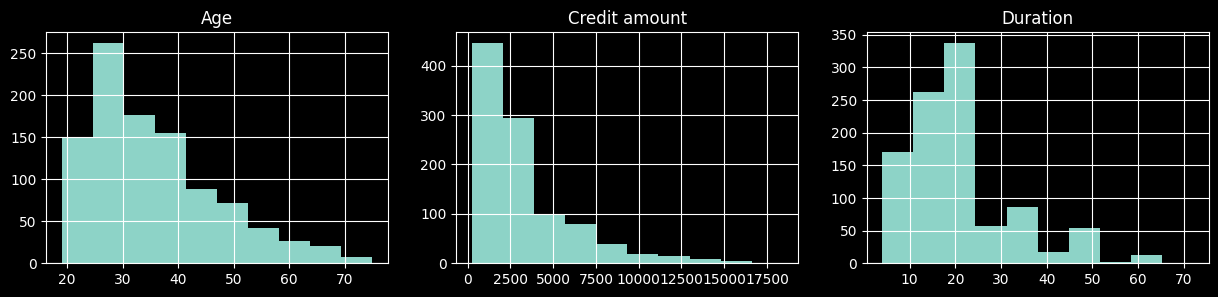

In [5]:
fig, ax = plt.subplots(1,3, figsize=(15,3))
df_num['Age'].hist(ax=ax[0])
ax[0].set_title('Age')
df_num['Credit amount'].hist(ax=ax[1])
ax[1].set_title('Credit amount')
df_num['Duration'].hist(ax=ax[2])
ax[2].set_title('Duration')

In [6]:
pd.concat([target, df_bool], axis=1).describe().loc[['mean', 'std'],:].T * 100

,mean,std
Risk,70.0,45.848687
Sex,69.0,46.272466
Job_0,2.2,14.675673
Job_1,20.0,40.020015
Job_2,63.0,48.304589
Job_3,14.8,35.527767
Saving accounts_little,60.3,48.952082
Saving accounts_moderate,10.3,30.411097
Saving accounts_quite rich,6.3,24.308453
Saving accounts_rich,4.8,21.387319


In [7]:
from src.utils import DataCollection
from sklearn.preprocessing import KBinsDiscretizer

binarizer = KBinsDiscretizer(strategy='uniform')
data = DataCollection(df_bool.values, df_num.values, target.values, binarizer=binarizer)

# Model

In [8]:
import fcapy
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import LineVizNx
from fcapy.poset import POSet

from src.model import ConceptNetwork

In [9]:
K_train = FormalContext(data.x['train'].numpy().astype(bool), target=data.y['train'].numpy().astype(bool))
L_train = ConceptLattice.from_context(K_train, algo='Sofia', L_max=10, is_monotone=True)

In [10]:
def select_best_concepts(lattice, context, measure='f1_score', n_concepts=10):
    lattice_ = copy(lattice)
    for concept in lattice_:
        y_preds = np.zeros(context.n_objects)
        y_preds[list(concept.extent_i)] = 1
        concept.measures['f1_score'] = f1_score(context.target, y_preds)
        concept.measures['support'] = concept.support

    best_concepts = lattice_.measures[measure].argsort()[::-1][:n_concepts]

    if len({g_i for c in lattice_[best_concepts] for g_i in c.extent_i}) != context.n_objects:
        raise ValueError("Selected concepts do not cover all train objects")
    return lattice[best_concepts]

In [11]:
# best_concepts = select_best_concepts(L_train, K_train, measure='support', n_concepts=20)
best_concepts = [c for c in L_train if c.intent]
cn = ConceptNetwork(best_concepts, nonlinearity=nn.ReLU)

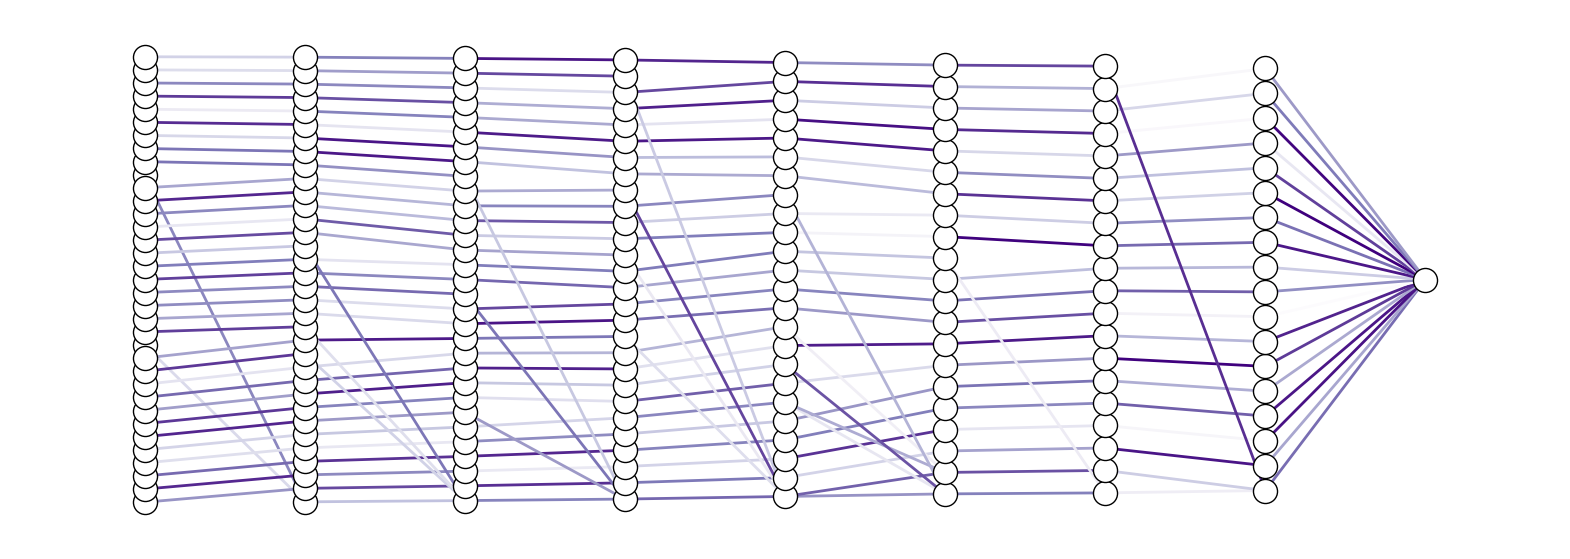

In [12]:
fig = plt.figure(figsize=(20,7))
cn.plot_network(edge_cmap=plt.cm.Purples, node_color='w', edgecolors='black', width=2)

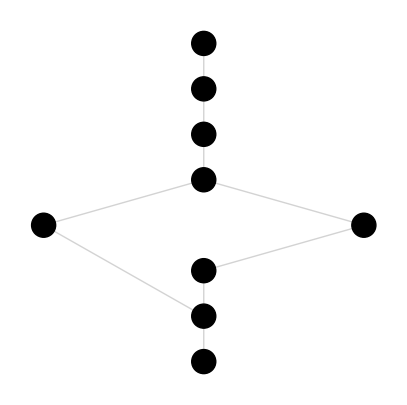

In [13]:
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(5,5))
    vis = LineVizNx(node_border_color='black', node_color='black')
    vis.draw_poset(POSet(best_concepts), ax=ax);

## Training

In [14]:
cn = ConceptNetwork(best_concepts, nonlinearity=nn.ReLU)

In [15]:
def train(model, data, epochs=1000, lr=1e-3, weight_decay=0):
    x = data.x['train']
    y = data.y['train'][:,None]
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.BCELoss()

    losses = []
    for t in tqdm(range(epochs)):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    return losses

In [16]:
losses = train(cn, data, epochs=1000, lr=1e-3)

100%|██████████| 1000/1000 [00:06<00:00, 154.29it/s]


0.6177605986595154


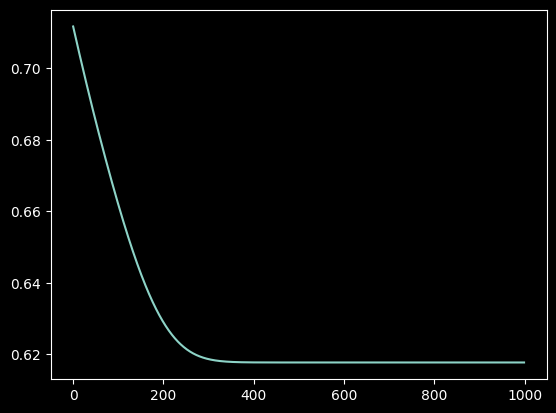

In [17]:
plt.plot(losses)
print(losses[-1])

In [18]:
x_val = data.x['val']
y_val = data.y['val'][:,None]
with torch.no_grad():
    y_pred = cn(x_val) > 0.5
    print(f1_score(y_pred, y_val))

0.8200589970501475


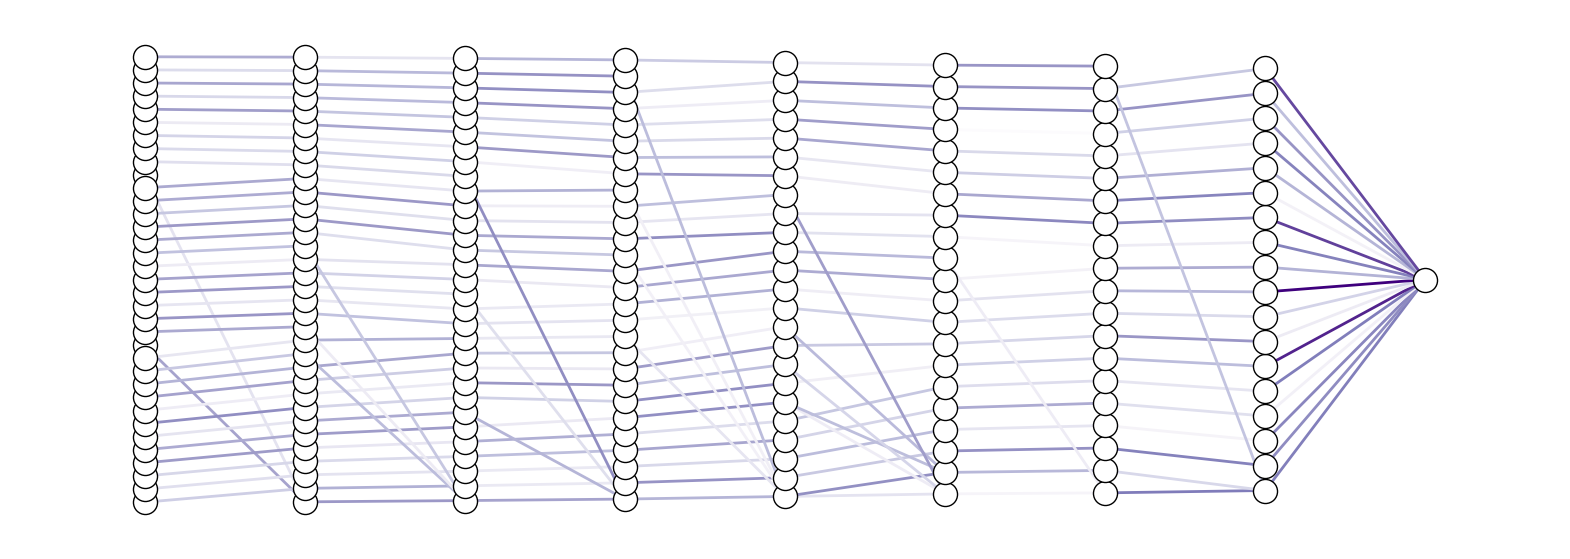

In [19]:
fig = plt.figure(figsize=(20,7))
cn.plot_network(edge_cmap=plt.cm.Purples, node_color='w', edgecolors='black', width=2)

# Experiments

In [20]:
x_val = data.x['val']
y_val = data.y['val'][:,None]

for act in [nn.ReLU, nn.Tanh, nn.Sigmoid]:
    torch.manual_seed(1)
    cn = ConceptNetwork(best_concepts, nonlinearity=act)
    train(cn, data, epochs=5000, lr=1e-3)
    with torch.no_grad():
        y_pred = cn(x_val) > 0.5
        print(act.__name__, f1_score(y_pred, y_val))

100%|██████████| 5000/5000 [00:27<00:00, 180.22it/s]


ReLU 0.8200589970501475


100%|██████████| 5000/5000 [00:30<00:00, 162.45it/s]


Tanh 0.809688581314879


100%|██████████| 5000/5000 [00:31<00:00, 158.37it/s]

Sigmoid 0.8200589970501475


In [21]:
for s in ['uniform', 'quantile']:
    binarizer = KBinsDiscretizer(strategy=s)
    data_ = DataCollection(df_bool.values, df_num.values, target.values, binarizer=binarizer)
    torch.manual_seed(1)
    cn = ConceptNetwork(best_concepts, nonlinearity=nn.ReLU)
    train(cn, data_, epochs=5000, lr=1e-3)
    with torch.no_grad():
        y_pred = cn(x_val) > 0.5
        print(s, f1_score(y_pred, y_val))

100%|██████████| 5000/5000 [00:26<00:00, 188.88it/s]


uniform 0.8200589970501475


100%|██████████| 5000/5000 [00:26<00:00, 189.19it/s]

quantile 0.8200589970501475


In [22]:
for c in [10,20,30,40,50]:
    K_train = FormalContext(data.x['train'].numpy().astype(bool), target=data.y['train'].numpy().astype(bool))
    L_train = ConceptLattice.from_context(K_train, algo='Sofia', L_max=c, is_monotone=True)
    best_concepts = [c for c in L_train if c.intent]
    torch.manual_seed(1)
    cn = ConceptNetwork(best_concepts, nonlinearity=nn.ReLU)
    train(cn, data_, epochs=5000, lr=1e-3)
    with torch.no_grad():
        y_pred = cn(x_val) > 0.5
        print(c, f1_score(y_pred, y_val))

9


100%|██████████| 5000/5000 [00:27<00:00, 179.79it/s]


10 0.8200589970501475
17


100%|██████████| 5000/5000 [00:36<00:00, 136.67it/s]


20 0.8200589970501475
22


100%|██████████| 5000/5000 [00:34<00:00, 144.83it/s]


30 0.8200589970501475
36


100%|██████████| 5000/5000 [01:09<00:00, 72.38it/s]


40 0.8200589970501475
49


100%|██████████| 5000/5000 [01:07<00:00, 73.56it/s]

50 0.8200589970501475


# Model comparison

knn, random forests, boosting, mlp, tabnet

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [24]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(data.x['train'], data.y['train'])
print(f1_score(knn.predict(data.x['test']), data.y['test']))

knn_num = KNeighborsClassifier(n_neighbors=50)
knn_num.fit(data.x_num['train'], data.y['train'])
print(f1_score(knn_num.predict(data.x_num['test']), data.y['test']))


0.8520710059171598
0.8454810495626822


In [25]:
rf = RandomForestClassifier(n_estimators=200, random_state=1)
rf.fit(data.x['train'], data.y['train'])
print(f1_score(rf.predict(data.x['test']), data.y['test']))

rf_num = RandomForestClassifier(n_estimators=200, random_state=1)
rf_num.fit(data.x_num['train'], data.y['train'])
print(f1_score(rf_num.predict(data.x_num['test']), data.y['test']))

0.8333333333333334
0.8338762214983713


In [26]:
lr = LogisticRegression()
lr.fit(data.x['train'], data.y['train'])
print(f1_score(lr.predict(data.x['test']), data.y['test']))

lr_num = LogisticRegression()
lr_num.fit(data.x_num['train'], data.y['train'])
print(f1_score(lr_num.predict(data.x_num['test']), data.y['test']))

0.8143322475570033
0.8211920529801324


In [32]:
mlp = MLPClassifier(hidden_layer_sizes=[128,128,128,32], max_iter=1000, learning_rate_init=1e-3, random_state=1, n_iter_no_change=100)
mlp.fit(data.x['train'], data.y['train'])
print(f1_score(mlp.predict(data.x['test']), data.y['test']))

mlp_num = MLPClassifier(hidden_layer_sizes=[128,128,128,32], max_iter=1000, learning_rate_init=1e-3, random_state=1, n_iter_no_change=100)
mlp_num.fit(data.x_num['train'], data.y['train'])
print(f1_score(mlp_num.predict(data.x_num['test']), data.y['test']))

0.8200000000000001
0.7578947368421054


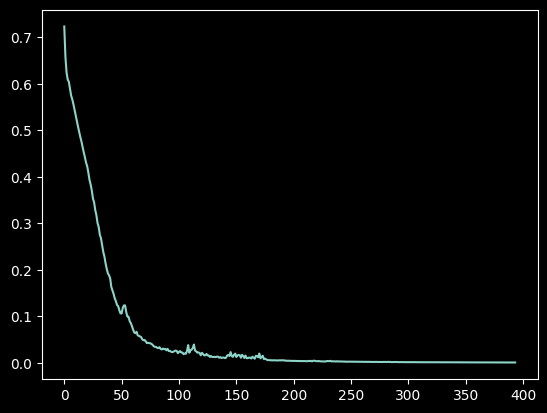

In [31]:
plt.plot(mlp.loss_curve_)

In [37]:
K_train = FormalContext(data.x['train'].numpy().astype(bool), target=data.y['train'].numpy().astype(bool))
L_train = ConceptLattice.from_context(K_train, algo='Sofia', L_max=10, is_monotone=True)
best_concepts = [c for c in L_train if c.intent]

torch.manual_seed(1)
cn = ConceptNetwork(best_concepts, nonlinearity=nn.ReLU)
train(cn, data, epochs=5000, lr=1e-3)
with torch.no_grad():
    y_pred = cn(data.x['test']) > 0.5
    print(f1_score(y_pred, data.y['test']))

100%|██████████| 5000/5000 [00:30<00:00, 163.13it/s]

0.8439306358381503
